# Proyek Klasifikasi Gambar: [Breed Classification Dog]
- **Nama:** [Nur Huda Riyantoni]
- **Email:** [riyantoni2772@gmail.com]
- **ID Dicoding:** [Nur Huda Riyantoni]

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import cv2
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import random
from random import sample
import shutil

In [2]:
import tqdm
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers

## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nurhudariyantoni","key":"e1d6e054c1fceca59654f119bd2f4b74"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d yapwh1208/dogs-breed-dataset

Dataset URL: https://www.kaggle.com/datasets/yapwh1208/dogs-breed-dataset
License(s): CC-BY-NC-SA-4.0
 89% 563M/629M [00:03<00:01, 65.5MB/s]
100% 629M/629M [00:03<00:00, 193MB/s] 


In [7]:
!unzip dogs-breed-dataset.zip

Archive:  dogs-breed-dataset.zip
  inflating: dog_v1/french_bulldog/0200259a-2722-4576-86fb-6ead7393d8a0.jpg  
  inflating: dog_v1/french_bulldog/0c28471d0832854c0206dc3d4a563e93.jpg  
  inflating: dog_v1/french_bulldog/100e702566c23d7f711b7d69f415c735.jpg  
  inflating: dog_v1/french_bulldog/14747-2116.jpg  
  inflating: dog_v1/french_bulldog/14959-1992.jpg  
  inflating: dog_v1/french_bulldog/15072-4692.jpg  
  inflating: dog_v1/french_bulldog/15491-2365.jpg  
  inflating: dog_v1/french_bulldog/21767-8375.jpg  
  inflating: dog_v1/french_bulldog/21768-1518.jpg  
  inflating: dog_v1/french_bulldog/22310-5589.jpg  
  inflating: dog_v1/french_bulldog/2c8df8a81189a6f22c928dafd6266cee.jpg  
  inflating: dog_v1/french_bulldog/33-1024x1024.jpg  
  inflating: dog_v1/french_bulldog/36d03c999a9aa228dfdec3e21d9569bc.jpg  
  inflating: dog_v1/french_bulldog/37041515_2569746716384667_2807571631214428160_n.jpg  
  inflating: dog_v1/french_bulldog/38d460cecae7c959ecca7d3d2c38b396.jpg  
  inflating:

In [8]:
data_dir = '/content/dog_v1'

Menghitung Jumlah kelas

In [9]:
classes= []
for file in os.listdir(data_dir):
  classes+=[file]
print(f'Jumlah kelas berjumlah {len(classes)}, yaitu:')
print(classes)

JUMLAH_CLASS = len(classes)

Jumlah kelas berjumlah 5, yaitu:
['poodle', 'german_shepherd', 'yorkshire_terrier', 'french_bulldog', 'golden_retriever']


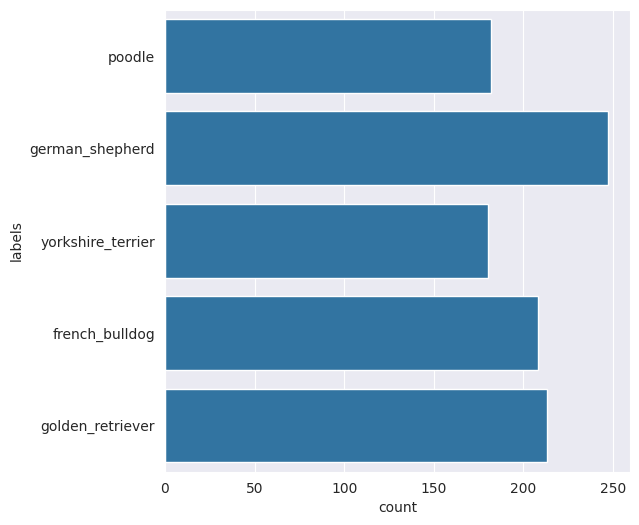

In [10]:
# Definisikan path sumber
dog_path = "/content/dog_v1"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(dog_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sn.set_style("darkgrid")
plot_data = sn.countplot(Label)

Menampilkan Gambar dari masing-masing kelas

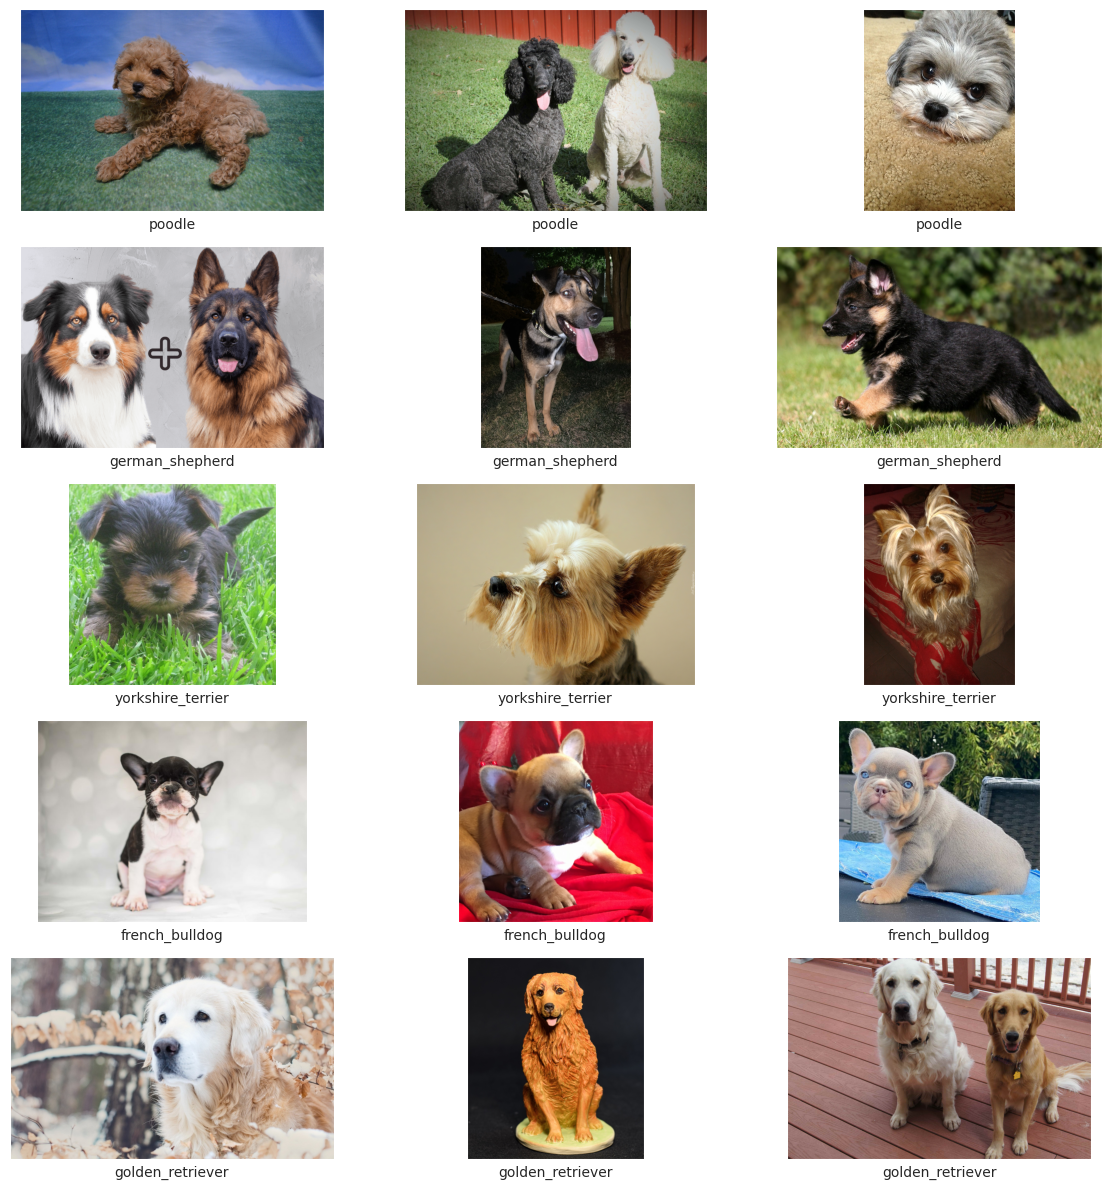

In [11]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
cat_image ={}

path = '/content/dog_v1'
path_sub = path
for i in os.listdir(path_sub):
  cat_image[i]= os.listdir(os.path.join(path_sub,i))

# Menampilkan secara acak 3 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(cat_image.keys()), 3, figsize=(12, 12))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(cat_image[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Preprocessing

Augmentation

In [12]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (160,160))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image


In [13]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

for i in classes:
  images_path="/content/dog_v1/"+i # Path untuk gambar asli
  augmented_path="/content/dog_v1/"+i # Path untuk gambar yang sudah diaugmentasi
  images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
  for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
  images_to_generate=1000
  i=1

  while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be conv

Jumlah data setelah augmentasi

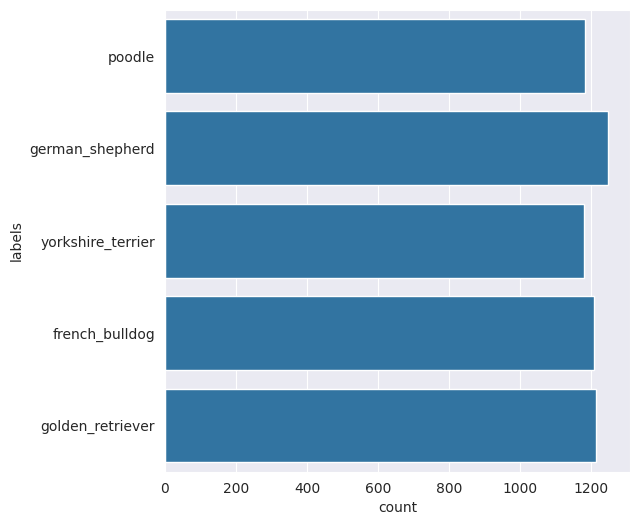

In [14]:
# Definisikan path sumber
dog_path = "/content/dog_v1"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(dog_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sn.set_style("darkgrid")
plot_data = sn.countplot(Label)

In [15]:
dataset=[]
testset=[]

count=0
shape=(160,160)

for file in os.listdir(data_dir):
  path = os.path.join(data_dir,file)
  t=0
  for an in tqdm.tqdm(os.listdir(path)):
    gambar = load_img(os.path.join(path,an), color_mode='rgb',target_size=shape)
    gambar = img_to_array(gambar)
    gambar = gambar/255.0
    dataset+=[[gambar,count]]
    t+=17
  count=count+1

 47%|████▋     | 589/1247 [00:04<00:04, 139.00it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 70%|███████   | 878/1247 [00:06<00:03, 119.57it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1213/1213 [00:07<00:00, 166.64it/s]


In [16]:
data,labels = zip(*dataset)

labels = tf.keras.utils.to_categorical(labels)
print(labels.shape)
labels= np.array(labels)
data = np.array(data, dtype=np.float32)

(6030, 5)


#### Split Dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=300) #split for data training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=300) #split for data validation

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3617, 160, 160, 3)
(905, 160, 160, 3)
(1508, 160, 160, 3)
(3617, 5)
(905, 5)
(1508, 5)


## Modelling

In [32]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Awalnya frozen layer pretrained model

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,093 (10.02 MB)

 Trainable params: 369,045 (1.41 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.optimizers.Adam(),
              metrics=['accuracy'])

In [35]:
his=model.fit(X_train, y_train,validation_data=(X_val,y_val),callbacks=callbacks,epochs=50)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.6247 - loss: 1.5388 - val_accuracy: 0.8575 - val_loss: 0.7916 - learning_rate: 0.0010
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7740 - loss: 0.8439 - val_accuracy: 0.8497 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7913 - loss: 0.7479 - val_accuracy: 0.8088 - val_loss: 0.7626 - learning_rate: 0.0010
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7998 - loss: 0.7136 - val_accuracy: 0.8619 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8074 - loss: 0.7041 - val_accuracy: 0.8773 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8082 - loss: 0.7305 - val_accuracy: 0.7702 - val_loss: 0.9769 - learning_rate: 0.0010
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8202 - loss: 

## Evaluasi dan Visualisasi

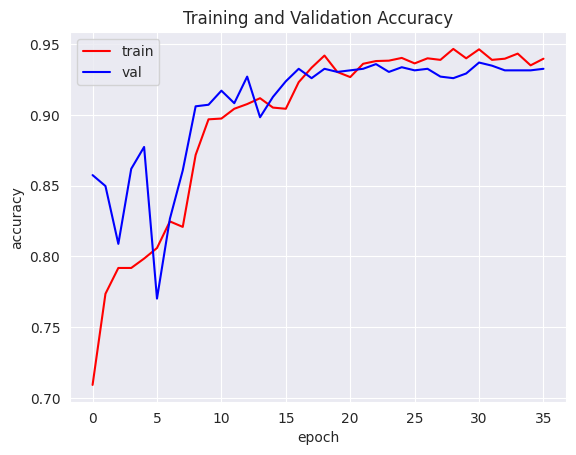

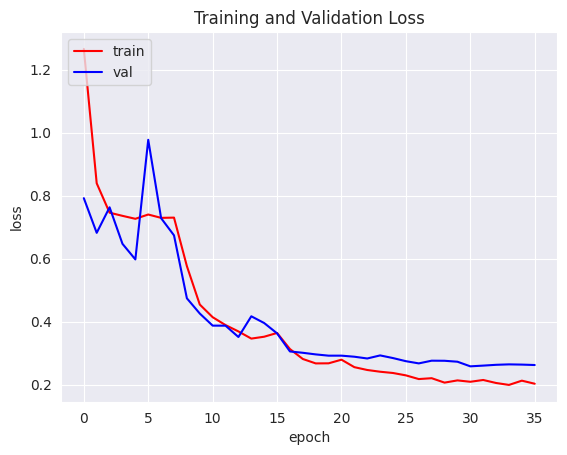

In [36]:
acc = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# Prediksi hasil
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi ke label kelas
y_test_classes = np.argmax(y_test, axis=1) # Konversi y_test ke label kelas

# Tampilkan classification report
print(classification_report(y_test_classes, y_pred_classes))

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       294
           1       0.91      0.90      0.91       297
           2       0.92      0.92      0.92       305
           3       0.95      0.95      0.95       327
           4       0.91      0.94      0.93       285

    accuracy                           0.92      1508
   macro avg       0.92      0.92      0.92      1508
weighted avg       0.92      0.92      0.92      1508



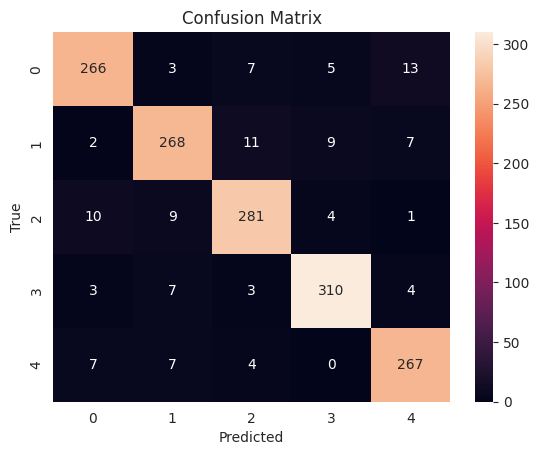

In [38]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Visualize the confusion matrix using seaborn's heatmap
sn.heatmap(cm, annot=True, fmt='d')  # 'd' for integer formatting
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

Saved Model

In [39]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

Convert ke TFLite

In [40]:
# Load model dari SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')

# Konversi model ke format TFLite
tflite_model = converter.convert()

# Simpan model TFLite di dalam folder "tflite"
os.makedirs('tflite', exist_ok=True)
tflite_model_path = "tflite/model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Simpan label (jika ada) ke dalam "tflite/label.txt"
labels = classes
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

Convert ke Tensorflow JS

In [ ]:
pip install tensorflowjs

In [42]:
!tensorflowjs_converter \
    --input_format tf_saved_model \
    --output_node_names 'MobilenetV2/Predictions/Reshape_1' \
    /content/saved_model/ \
    /content/modeltfjs

2025-05-27 07:11:59.418365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748329919.572489   10362 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748329919.630210   10362 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-27 07:12:12.749242: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748329932.749441   10362 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

 Kompress folder keluaran model

In [44]:
# Kompres folder tflite menjadi tflite.zip
shutil.make_archive("tflite", 'zip', "tflite")

# Download file ZIP
from google.colab import files
files.download("tflite.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
# Kompres folder saved_model menjadi saved_model.zip
shutil.make_archive("saved_model", 'zip', "saved_model")

# Download file ZIP
from google.colab import files
files.download("saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# Kompres folder modeltfjs menjadi modeltfjs.zip
shutil.make_archive("modeltfjs", 'zip', "modeltfjs")

# Download file ZIP
from google.colab import files
files.download("modeltfjs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 pip freeze > requirements.txt